# DiffEqBiological Tutorial I: Introduction

In this tutorial we'll provide an introduction to using DiffEqBiological to specify chemical reaction networks, and then to solve ODE, jump, $\tau$-leaping and SDE models for them. In subsequent notebooks we'll explore in more detail network specification and working with the solvers for different types of models.

Let's start by using the DiffEqBiological `reaction_network` DSL to specify a simply chemical reaction network; the well-known Repressilator. We first import the basic packages we'll need, and use PyPlot for making figures:

In [15]:
using DifferentialEquations, DiffEqBiological, Plots, Latexify;
pyplot();

We next construct the reaction network. The basic types of arrows and predefined rate laws one can use are discussed in the DiffEqBiological [documentation](http://docs.juliadiffeq.org/latest/models/biological.html), and more fully explored in the second tutorial. Here we use a mix of first order, zero order and repressive Hill function rate laws. Note, $\varnothing$ corresponds to the empty state, and is used for zeroth order production and first order degradation reactions:

In [16]:
repressilator = @reaction_network begin
    hillr(P₃,α,K,n), ∅ --> m₁
    hillr(P₁,α,K,n), ∅ --> m₂
    hillr(P₂,α,K,n), ∅ --> m₃
    (δ,γ), m₁ ↔ ∅
    (δ,γ), m₂ ↔ ∅
    (δ,γ), m₃ ↔ ∅
    β, m₁ --> m₁ + P₁
    β, m₂ --> m₂ + P₂
    β, m₃ --> m₃ + P₃
    μ, P₁ --> ∅
    μ, P₂ --> ∅
    μ, P₃ --> ∅
end α K n δ γ β μ

(::reaction_network) (generic function with 2 methods)

We can use Latexify to look at the corresponding reactions

In [17]:
latexify(repressilator; env=:chemical)

L"\begin{align}
\require{mhchem}
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_3^{n}}] m_{1}}\\
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_1^{n}}] m_{2}}\\
\ce{ \varnothing &->[\frac{\alpha \cdot K^{n}}{K^{n} + P_2^{n}}] m_{3}}\\
\ce{ m_{1} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{2} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{3} &<=>[\delta][\gamma] \varnothing}\\
\ce{ m_{1} &->[\beta] m_{1} + P_{1}}\\
\ce{ m_{2} &->[\beta] m_{2} + P_{2}}\\
\ce{ m_{3} &->[\beta] m_{3} + P_{3}}\\
\ce{ P_{1} &->[\mu] \varnothing}\\
\ce{ P_{2} &->[\mu] \varnothing}\\
\ce{ P_{3} &->[\mu] \varnothing}
\end{align}
"

or to look at the corresponding ODEs:

In [18]:
latexify(repressilator)

L"\begin{align}
\frac{dm_1}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_3^{n}} - \delta \cdot m_1 + \gamma + 0 \\
\frac{dm_2}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_1^{n}} - \delta \cdot m_2 + \gamma + 0 \\
\frac{dm_3}{dt} =& \frac{\alpha \cdot K^{n}}{K^{n} + P_2^{n}} - \delta \cdot m_3 + \gamma + 0 \\
\frac{dP_1}{dt} =& \beta \cdot m_1 - \mu \cdot P_1 \\
\frac{dP_2}{dt} =& \beta \cdot m_2 - \mu \cdot P_2 \\
\frac{dP_3}{dt} =& \beta \cdot m_3 - \mu \cdot P_3 \\
\end{align}
"

To solve the ODEs we need to specify the values of the parameters in the model, the initial condition and the time interval to solve the model on. To do this it often helps to know the orderings of the parameters and the species. For the parameters, they are ordered in the same order they appear after the `end` statement in the `@reaction_network` macro. The species are ordered in the order they first appear within the `@reaction_network` macro. We can see these orderings by looking at the `syms_to_ints` and `params_to_ints` fields of the generated `reaction_network`:

In [19]:
repressilator.syms_to_ints

OrderedCollections.OrderedDict{Symbol,Int64} with 6 entries:
  :m₁ => 1
  :m₂ => 2
  :m₃ => 3
  :P₁ => 4
  :P₂ => 5
  :P₃ => 6

In [34]:
repressilator.params_to_ints

OrderedCollections.OrderedDict{Symbol,Int64} with 7 entries:
  :α => 1
  :K => 2
  :n => 3
  :δ => 4
  :γ => 5
  :β => 6
  :μ => 7

---
## Solving the ODEs
Knowing these orderings, we can create parameter and initial condition vectors, and setup the `ODEProblem` we want to solve:

In [21]:
# parameters
p = (.5, 40, 2, log(2)/120, 5e-3, 20*log(2)/120, log(2)/60)

# initial condition
u0 = [0.,0.,0.,20.,0.,0.]

# time to solve over
tspan = (0., 10000.)

# create the ODEProblem we want to solve
oprob = ODEProblem(repressilator, u0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10000.0)
u0: [0.0, 0.0, 0.0, 20.0, 0.0, 0.0]

At this point we are all setup to solve the ODEs. We can now use any ODE solver from within the DiffEq package. We'll just use the default DifferentialEquations solver for now, and then plot the solutions:

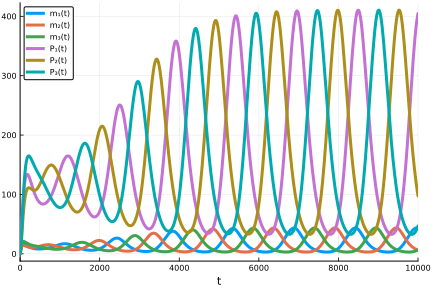

In [22]:
sol = solve(oprob, saveat=10.)
plot(sol, fmt=:svg)

So we see the well-known oscillatory behavior of the repressilator!

---

## Stochastic Simulation Algorithms (SSAs) for Stochastic Chemical Kinetics
Let's now look at a stochastic version of the repressilator, modeling it with jump processes. Here we will construct a `JumpProblem` that uses Gillespie's Direct method, and then solve it to generate one realization of the jump process. In constructing the `JumpProblem` we could have used any of the SSAs that are part of DiffEqJump instead of the `Direct` method:

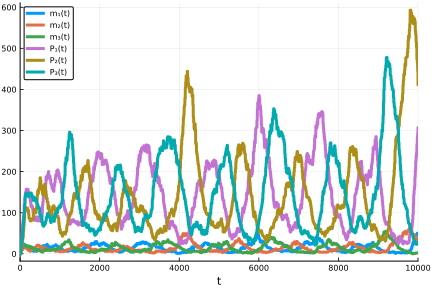

In [23]:
# first we redefine the initial condition to be integer valued
u0 = [0,0,0,20,0,0]

# first we create a discrete problem to encode that our species are integer valued:
dprob = DiscreteProblem(repressilator, u0, tspan, p)

# now we create a JumpProblem, and specify Gillespie's Direct Method as the solver:
jprob = JumpProblem(dprob, Direct(), repressilator, save_positions=(false,false))

# now let's solve and plot the jump process:
sol = solve(jprob, SSAStepper(), saveat=10.)
plot(sol, fmt=:svg)

Here we see that oscillations remain, but become much noiser.

---
## $\tau$-leaping Methods:
While SSAs generate exact realizations for stochastic chemical kinetics jump process models, [$\tau$-leaping](https://en.wikipedia.org/wiki/Tau-leaping) methods offer a performant alternative by discretizing in time the underlying time-change representation of the stochastic process. The DiffEqJump package has limited support for $\tau$-leaping methods in the form of the basic Euler's method type approximation proposed by Gillespie. We can use it to simulate the repressilator by constructing a `JumpProblem` from the `reaction_network.regular_jumps` field:

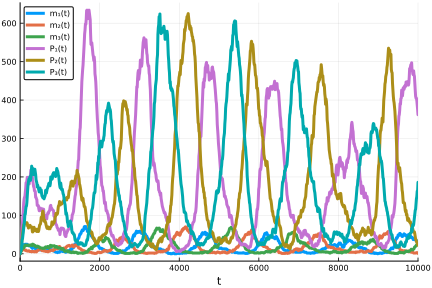

In [39]:
lprob = JumpProblem(dprob, Direct(), repressilator.regular_jumps)
lsol = solve(lprob, SimpleTauLeaping(), dt=.1)
plot(lsol, plotdensity=1000, fmt=:svg)

---

## Chemical Langevin Equation (CLE) Stochastic Differential Equation (SDE) Models:
At an intermediary physical scale between macroscopic ODE models and microscopic stochastic chemical kinetic models lies the CLE, a SDE version of the model. The SDEs add to each ODE above a noise term. As the repressilator has species that get very close to zero in size, it is not a good candidate to model with the CLE (where solutions can then go negative and become unphysical). Let's try create a simpler reaction network for a birth-death process that will stay non-negative:

In [24]:
bdp = @reaction_network begin
  c1, X --> 2X
  c2, X --> 0
  c3, 0 --> X
end c1 c2 c3
p = (1.0,2.0,50.)
tspan = (0.,4.)
u0 = [5.]

1-element Array{Float64,1}:
 5.0

The ODEs and noise terms are then

In [25]:
latexify(bdp)

L"\begin{align}
\frac{dX}{dt} =& c1 \cdot X - c2 \cdot X + c3 \\
\end{align}
"

In [26]:
latexify(bdp, noise=true)

L"\begin{align}
\frac{dX}{dt} =& \sqrt{\left\|c1 \cdot X\right\|} - \sqrt{\left\|c2 \cdot X\right\|} + \sqrt{\left\|c3\right\|} \\
\end{align}
"

Note, the noise terms are on the right of the equals sign, and correspond to the coefficient of a Gaussian White Noise, $\eta(t)$, that would be added to the ODE version of the model.

We can solve the corresponding CLE SDE model by creating an SDEProblem and solving it similar to what we did for ODEs above:

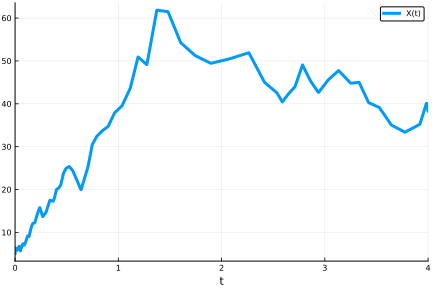

In [27]:
# SDEProblem for CLE
sprob = SDEProblem(bdp, u0, tspan, p)

# solve and plot
sol = solve(sprob, saveat=.004)
plot(sol, fmt=:svg)

---

## TODO
1. explain fields within the macro that might be useful
2. steady state problems
3. parameter estimation
4. sensitivity analysis
5. plotting network?